In [86]:
!pip3 install folium # creating interactive maps and visualizing data on top of geographic maps
!pip3 install adtk  # data analysis and exploration

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image
import warnings
import folium
import time
import calendar
from datetime import datetime as dt
from adtk.data import validate_series
warnings.filterwarnings("ignore")

# **Importing Dataset:**

In [ ]:
# Importing twelve .csv files:
se = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202209-divvy-publictripdata.csv")
oc = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202210-divvy-tripdata.csv")
no = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202211-divvy-tripdata.csv")
de = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202212-divvy-tripdata.csv")
ja = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202301-divvy-tripdata.csv")
fe = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202302-divvy-tripdata.csv")
mar = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202303-divvy-tripdata.csv")
ap = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202304-divvy-tripdata.csv")
may = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202305-divvy-tripdata.csv")
jun = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202306-divvy-tripdata.csv")
jul = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202307-divvy-tripdata.csv")
au = pd.read_csv("/kaggle/input/divvy-dataset-2022-2023/202308-divvy-tripdata.csv")

In [ ]:
# Each set contains 12 columns  
au.head()

# **Combining of dataset into a single file:**

In [ ]:
#Multiple data series concatenated , 12 columns:
divvy = pd.concat([se, oc, no, de, ja, fe, mar, ap, may, jun, jul, au],ignore_index=True, sort =False)
#First five rows called:
divvy.head()

In [ ]:
print("The dataset contains (rows, columns): ")
divvy.shape

In [ ]:
divvy.info()

Data type for started at and ended at currently in 'object' datatype which will be converted to 'datetime' datatype.

In [ ]:
#Checking for missing values, significant number of nulls:
divvy.isnull().sum()

Significant number of nulls for start and end station ID's not critical to this analysis thus can be dropped.

In [ ]:
divvy.head(2)

In [ ]:
divvy.duplicated().sum()

In [ ]:
divvy.duplicated('ride_id').sum()

There are no duplicated rows in this dataset, each ride id represents a unique value.

In [ ]:
#  Ride id lengths are of 16 characters, all columns counted:
divvy['rideid_length'] = divvy['ride_id'].apply(len)
divvy['rideid_length'].count()

In [ ]:
divvy['ride_id'].count()

In [ ]:
#Only two unique member types:
divvy['member_casual'].unique()

In [ ]:
divvy.describe()

In [ ]:
divvy.columns

Initial plotting of data pre-cleaning:

In [ ]:
ridetotal = divvy['ride_id'].shape[0]
membertotal = divvy[divvy['member_casual'] == 'member'].shape[0]
casualtotal = divvy[divvy['member_casual'] == 'casual'].shape[0]


In [ ]:
print('Prior to cleaning of data set, in the twelve months covered,', ridetotal, 'rides were taken.')
print('Prior to cleaning, the total member count is', membertotal, 'and casual count is', casualtotal,)

# Data Cleaning:

In [ ]:
#Dropping of columns start and end station id:
divvy = divvy.drop(['start_station_id', 'end_station_id'], axis = 1)

In [ ]:
#Reformatting of data type:

divvy['started_at'] = pd.to_datetime(divvy['started_at'])
divvy['ended_at'] = pd.to_datetime(divvy['ended_at'])

In [ ]:
divvy.dtypes

In [ ]:
divvy['rideable_type'].unique()

In [ ]:
divvy.shape[0]

In [ ]:
#Identification of rideable types that incorrectly skew dataset
divvy = divvy[(divvy['rideable_type'] != 'docked bike')] 
#& (divvy['member_casual'] == 'casual')]
divvy.head()

118538 rows of docked bike, all of which are also considered 'casual' users to be dropped. Through a search it was found that docked bikes are not in operation. These are to be removed

In [ ]:
divvy['rideable_type'].unique()

In [ ]:
divvy.isnull().sum()

In [ ]:
divvy.shape[0]

In [ ]:
#Removal of underscore from rideable type values:
divvy['rideable_type'] = divvy['rideable_type'].str.replace('_', ' ')
divvy.head(2)

In [ ]:
# Convert the started at column to strings
divvy['start_hour'] = divvy['started_at'].dt.hour

# Extract the hour from the ended_at column
divvy['end_hour'] = divvy['ended_at'].dt.hour
divvy.head(2)

In [ ]:
divvy['week_day'] = divvy['started_at'].dt.day_name()
divvy['month'] = divvy['started_at'].dt.month_name()
divvy['week_in_year'] = divvy ['started_at'].dt.isocalendar().week
divvy['ride_duration'] = divvy['ended_at'] - divvy['started_at']
divvy.tail(2)

In [ ]:
#rides to be no less than 4 mins and no more than 24 hours:
divvy['ride_duration'] = pd.to_timedelta(divvy['ride_duration'])
divvy.loc[(divvy['ride_duration'] >= pd.Timedelta(minutes=4)) & (divvy['ride_duration'] <= pd.Timedelta(hours=24)), 'ride_duration'] = divvy['ride_duration']


In [ ]:
divvy['ride_duration']

In [ ]:
divvy.info()

In [ ]:
# Converting week day column to a numeral:
weekday_numeral_map = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

divvy['week_day'] = divvy['week_day'].map(weekday_numeral_map)

In [ ]:
# Converting month column to a numeral:
month_numeral_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October':10,
    'November':11,
    'December':12
}
divvy['month'] = divvy['month'].map(month_numeral_map)

In [ ]:
divvy['week_day'].isnull().sum()

In [ ]:
divvy.info()

In [ ]:
#Converting month column to a numeral:
divvy.head()

In [ ]:
divvy.columns

In [ ]:
divvy.head()

In [ ]:
divvy = divvy[divvy['started_at'] < divvy['ended_at']]
divvy.head(5)

In [ ]:
divvy = divvy[(divvy['ride_duration'] >= pd.Timedelta(minutes=1)) | (divvy['ride_duration'] <= pd.Timedelta(minutes=1440))]

In [ ]:
divvy['start_station_name'].isna().sum()

In [ ]:
divvy['end_station_name'].isna().sum()

In [ ]:
# Filter for rows with null values in all three columns
test = divvy[(divvy['end_station_name'].isna()) &
                 (divvy['end_lat'].isna()) &
                 (divvy['end_lng'].isna())]    
                                                                              
test

In [ ]:
# Drop rows with null values in all three columns
divvy.dropna(subset=['end_station_name', 'end_lat', 'end_lng'], inplace=True)

In [ ]:
divvy.isnull().sum()

In [ ]:
divvy.info()

In [ ]:
# Drop rows with missing values in start_station_name
divvy = divvy.dropna(subset=['start_station_name'])

In [ ]:
divvy.isnull().sum()

In [ ]:
divvy['start_station_name'].isna().sum()

In [ ]:
divvy.duplicated().sum()

In [ ]:
#checking total rde of member and casual ride user
divvy_member_casl=divvy.groupby("member_casual").agg(
    memcas_count = pd.NamedAgg(column = 'member_casual', aggfunc = 'count'), 
    avg_ride_period = pd.NamedAgg(column = 'ride_duration', aggfunc = 'mean')
).reset_index()

divvy_member_casl


In [ ]:
plt.figure(figsize = (20, 6))
div = divvy["member_casual"].value_counts().plot(kind = 'bar', color = ['red','orange'],  rot = 0)


for p in div.patches:
    div.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'black')
    div.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Rider Type', weight = "bold", color = "#D71313", fontsize = 14, labelpad = 20)
plt.ylabel('Count of Type', weight = "bold", color = "#D71313", fontsize = 14, labelpad = 20);

In [ ]:
# creating pie plot
divvy_member_casl.plot(kind='pie', y='memcas_count', autopct='%1.0f%%', colors=['yellow', '#3F95A4'],
                       title='Total rides by annual members and casual riders', figsize=(10, 6), labels=['Casual', 'Annual Member'])

# rotate x-axis ticks vertically
plt.xticks(rotation=1)

In [ ]:
# Analysis 2

# find out which days of the week each of the member groups are most active with which bikes.

weekly_divvy = divvy.groupby(['member_casual', 'week_day'])['rideable_type'].size().reset_index(name='num_of_weekly_rides')
casual_popular_day = weekly_divvy[weekly_divvy['member_casual'] == 'casual'].groupby('week_day')['num_of_weekly_rides'].max().reset_index().sort_values(by='num_of_weekly_rides', ascending=True)
member_popular_day = weekly_divvy[weekly_divvy['member_casual'] == 'member'].groupby('week_day')['num_of_weekly_rides'].max().reset_index().sort_values(by='num_of_weekly_rides', ascending=True)

In [ ]:
# For casual riders the most popular days are Saturday followed by Sunday and Friday
casual_popular_day

In [ ]:
# Plotting for member riders

casual_popular_day

palette = 'hls'

plt.figure(figsize=(14, 10))
ax = sns.barplot(x='week_day', y='num_of_weekly_rides', hue='week_day', data=casual_popular_day, palette='hls')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Casual: Weekday Ride ')
plt.xlabel('Week Day')
plt.ylabel('Number of Rides')
plt.show()


As the barchart demonstrates, for casual riders Saturday is the most popular day, followed by Sunday and Friday. 

In [ ]:
# For members the most popular day is Friday, followed by Tuesday and Wednesday
member_popular_day

In [ ]:
member_popular_day

palette = 'hls'

plt.figure(figsize=(14, 10))
ax = sns.barplot(x='week_day', y='num_of_weekly_rides', hue='week_day', data=member_popular_day, palette='hls')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Member: Weekday Ride ')
plt.xlabel('Week Day')
plt.ylabel('Number of Rides')
plt.show()

As the graph shows for Members there is a more consistent use throughout the whole week, with members also opting to use the bikes on weekdays, likely as a means of transport for work.

In [ ]:
casual_ride = divvy[(divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_casual = casual_ride.groupby(['member_casual', 'rideable_type', 'week_day']).size().reset_index(name='num_of_weekly_rides')

div_casual

In [ ]:
casual_ride = divvy[(divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_casual = casual_ride.groupby(['member_casual', 'rideable_type', 'week_day']).size().reset_index(name='num_of_weekly_rides')

palette = 'hls'

plt.figure(figsize=(14, 10))
ax = sns.barplot(x='week_day', y='num_of_weekly_rides', hue='rideable_type', data=div_casual, palette='hls')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Casual: Number of Rides by Day of Week and Rideable Type')
plt.xlabel('Week Day')
plt.ylabel('Number of Rides')
plt.show()

As this graph shows casual riders use cyclistic bikes largely on **Saturdays and Sundays**, with rides increasing from Thursday. Thus casual riders want a bike towards the end of the week for leisure.

In [ ]:
# Plotting for member riders

member_ride = divvy[divvy['member_casual'] == 'member']

div_member = member_ride.groupby(['rideable_type', 'week_day']).size().reset_index(name='num_of_weekly_rides')

palette = 'hls'

plt.figure(figsize=(14, 10))
ax = sns.barplot(x='week_day', y='num_of_weekly_rides', hue='rideable_type', data=div_member, palette='hls')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Member: Number of Rides by Day of Week and Rideable Type')
plt.xlabel('Week Day')
plt.ylabel('Number of Rides')
plt.show()



As the second bar chart demonstrates in a weekly timescale, member riders:
* Largely prefer to use **classic bikes** when riding.
* Rides are consistently taken by members throughout the week however,  more frequently on weekdays, particularly **Tuesday-Thursday**.

In [ ]:
casual_month_ride = divvy[(divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')] 
casual_month_ride.head(1)

In [ ]:
casual_month_ride = divvy[(divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_month_casual = casual_ride.groupby(['member_casual', 'rideable_type', 'month']).size().reset_index(name='num_of_monthly_rides')

div_month_casual

In [ ]:
# Analysis_3

# graphing the usage by bike type. Show total number of bike rides by month

plt.figure(figsize=(14, 8))
plot_3 = sns.barplot(x='month', y='num_of_monthly_rides', hue='rideable_type', data=div_month_casual, palette='viridis', errorbar=None)
plot_3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Casual: Cyclistic Bike Rides monthly', y=1, fontsize=12, )
plt.suptitle('Bike-Share Usage by Bike Type: Jan 2023 - June 2023', y=.95, fontsize=18, fontweight='bold',)

for p in plot_3.patches:
    plot_3.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.xlabel('User Type')
plt.ylabel('Number of Rides')
plt.show()

As the graph demonstrating monthly trends for casual riders shows, the most popular months are between late spring (May) and early October, generally recognised as the holiday season/period.

In [ ]:
member_month_ride = divvy[(divvy['member_casual'] == 'member') & (divvy['rideable_type'] != 'docked bike')]
div_month_member = member_month_ride.groupby(['member_casual', 'rideable_type', 'month']).size().reset_index(name='num_of_monthly_rides')

div_month_member

In [ ]:
#Analysis 4 month
# graphing the usage by bike type. Show total number of bike rides by month

plt.figure(figsize=(14, 8))
plot_3 = sns.barplot(x='month', y='num_of_monthly_rides', hue='rideable_type', data=div_month_member, palette='viridis', errorbar=None)
plot_3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Member: Cyclistic Bike Rides monthly', y=1, fontsize=12, )
plt.suptitle('Bike-Share Usage by Bike Type: Jan 2023 - June 2023', y=.95, fontsize=18, fontweight='bold',)

for p in plot_3.patches:
    plot_3.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.xlabel('User Type')
plt.ylabel('Number of Rides')
plt.show()

As the member cyclistic bike monthly trends demonstrates there is a more steady movement with fewer uses in the winter months and an increased usage between late spring (May) to early winter (Nov).

In [ ]:
#Yearly comparsion between casual and members:
memcas_weekyr_ride = divvy[(divvy['member_casual'] == 'member') | (divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_memcas_weekyr = memcas_weekyr_ride.groupby(['member_casual', 'week_in_year']).size().reset_index(name='num_wkyrly_rides')
div_memcas_weekyr

In [ ]:
plt.figure(figsize=(14, 8))
plot_3 = sns.barplot(x='week_in_year', y='num_wkyrly_rides', hue='member_casual', data=div_memcas_weekyr, palette='viridis', errorbar=None)
plt.title('Week of Year Comparison of Casual v Member Cyclistic Riders', y=1, fontsize=12, )
plt.suptitle('Bike-Share Usage by Bike Type: Jan 2023 - June 2023', y=.95, fontsize=18, fontweight='bold',)

for p in plot_3.patches:
    plot_3.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.xlabel('Week in Year')
plt.ylabel('Number of Rides')
plt.show()

In [94]:
#Plot ride duration 
memcas_duration = divvy[
    (
        (divvy["member_casual"] == "member")
        | (divvy["member_casual"] == "casual")
    )
    & (divvy["ride_duration"].dt.total_seconds() >= 4 * 60)
    & (divvy["ride_duration"].dt.total_seconds() <= 1440 * 60)
]
div_memcas_duration = memcas_duration.groupby(['member_casual', 'ride_duration']).size().reset_index(name='avg_rideduration')
div_memcas_duration 

,member_casual,ride_duration,avg_rideduration
0,casual,0 days 00:04:00,1115
1,casual,0 days 00:04:01,1144
2,casual,0 days 00:04:02,1110
3,casual,0 days 00:04:03,1155
4,casual,0 days 00:04:04,1222
...,...,...,...
27900,member,0 days 23:52:04,1
27901,member,0 days 23:53:18,1
27902,member,0 days 23:54:26,1
27903,member,0 days 23:54:45,1


In [ ]:
casual_ride_durations = divvy[divvy['member_casual'] == 'casual']['ride_duration']
member_ride_durations = divvy[divvy['member_casual'] == 'member']['ride_duration']

# Line plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    x=casual_ride_durations.dt.total_seconds()/60,
    y=casual_ride_durations.dt.total_seconds()/60,
    label='Casual Riders',
    alpha=0.7,
    linewidth=2,
)
sns.lineplot(
    x=member_ride_durations.dt.total_seconds()/60,
    y=member_ride_durations.dt.total_seconds()/60,
    label='Member Riders',
    alpha=0.7,
    linewidth=2,
)
plt.title('Average Ride Duration over Time', y=1, fontsize=12)
plt.suptitle('Bike-Share Usage by Bike Type: Jan 2023 - June 2023', y=.95, fontsize=18, fontweight='bold')
plt.xlabel('Ride Duration (mins)')
plt.ylabel('Average Ride Duration (minutes)')
plt.legend(title='Ride Type')
plt.grid(True)
plt.show()

In [ ]:
memcas_weekyr_ride = divvy[(divvy['member_casual'] == 'member') | (divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_memcas_weekyr = memcas_weekyr_ride.groupby(['member_casual', 'week_in_year']).size().reset_index(name='num_wkyrly_rides')
div_memcas_weekyr

In [88]:
start_ride = divvy[(divvy['member_casual'] == 'member') | (divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_start_hr = start_ride.groupby(['member_casual', 'start_hour']).size().reset_index(name='start_ride_hr')

div_start_hr 

,member_casual,start_hour,start_ride_hr
0,casual,0,25136
1,casual,1,16099
2,casual,2,9291
3,casual,3,4760
4,casual,4,3528
5,casual,5,7942
6,casual,6,22549
7,casual,7,38183
8,casual,8,51417
9,casual,9,49491


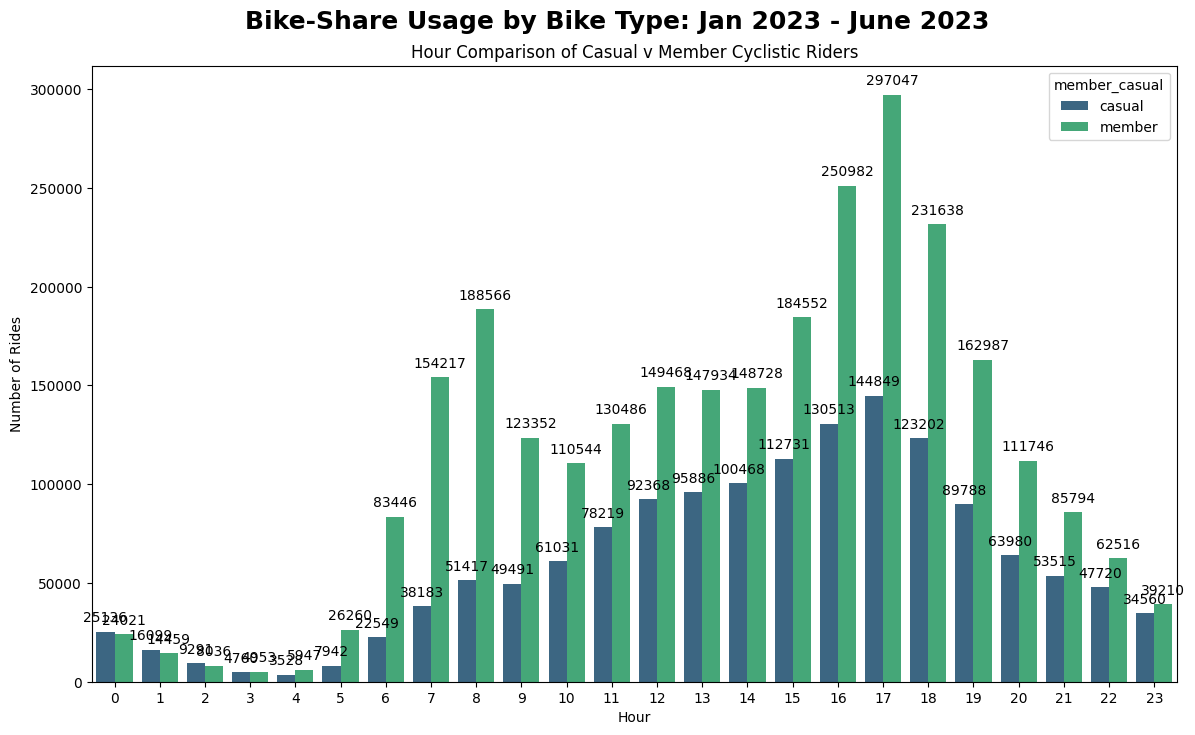

In [89]:
plt.figure(figsize=(14, 8))
plot_3 = sns.barplot(x='start_hour', y='start_ride_hr', hue='member_casual', data=div_start_hr, palette='viridis', errorbar=None)
plt.title('Start Hour Comparison of Casual v Member Cyclistic Riders', y=1, fontsize=12, )
plt.suptitle('Bike-Share Usage by Bike Type: Jan 2023 - June 2023', y=.95, fontsize=18, fontweight='bold',)

for p in plot_3.patches:
    plot_3.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.xlabel('Start Hour')
plt.ylabel('Number of Rides')
plt.show()

As the graph demonstartes the most popular start ride times for casual riders is between 4 -6pm, however members have a more varied spread, with a morning peak between 7-9am  and another ride between 3-7pm as the school and work day is ending. 

In [91]:
end_ride = divvy[(divvy['member_casual'] == 'member') | (divvy['member_casual'] == 'casual') & (divvy['rideable_type'] != 'docked bike')]
div_end_hr = end_ride.groupby(['member_casual', 'end_hour']).size().reset_index(name='end_ride_hr')

div_end_hr 

,member_casual,end_hour,end_ride_hr
0,casual,0,27323
1,casual,1,17556
2,casual,2,11288
3,casual,3,5659
4,casual,4,3620
5,casual,5,7016
6,casual,6,18821
7,casual,7,34377
8,casual,8,49309
9,casual,9,46101


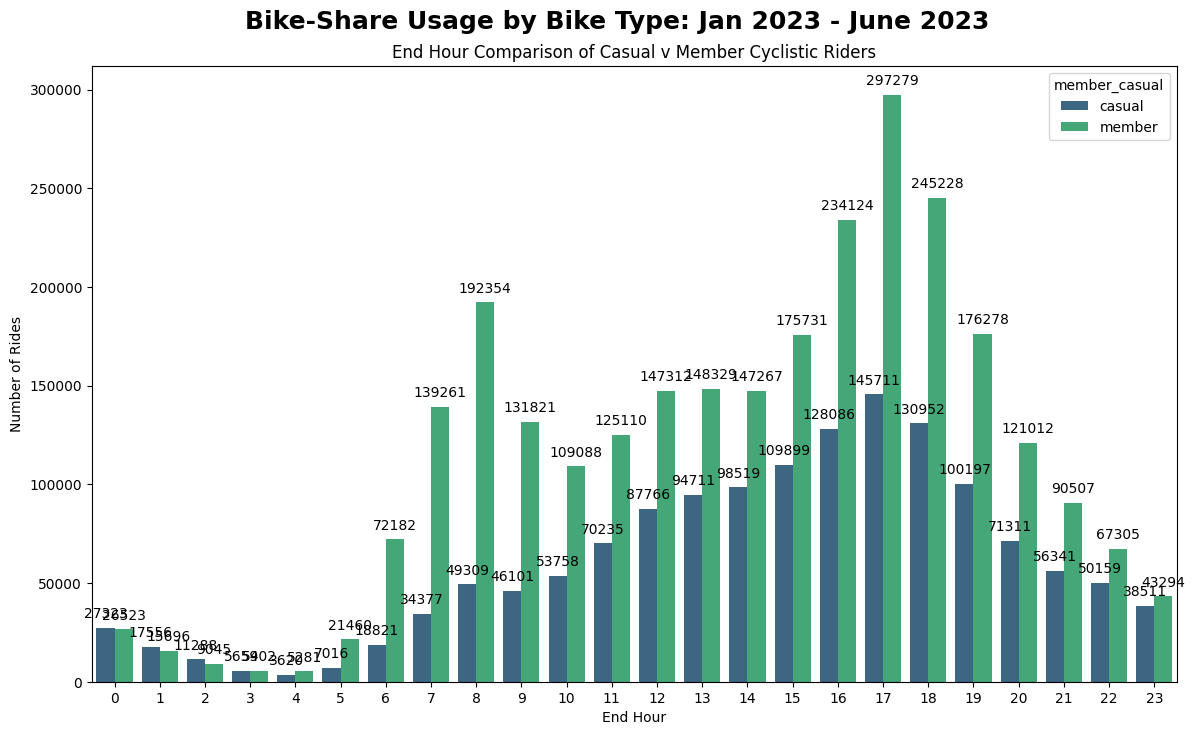

In [92]:
plt.figure(figsize=(14, 8))
plot_3 = sns.barplot(x='end_hour', y='end_ride_hr', hue='member_casual', data=div_end_hr, palette='viridis', errorbar=None)
plt.title('End Hour Comparison of Casual v Member Cyclistic Riders', y=1, fontsize=12, )
plt.suptitle('Bike-Share Usage by Bike Type: Jan 2023 - June 2023', y=.95, fontsize=18, fontweight='bold',)

for p in plot_3.patches:
    plot_3.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.xlabel('End Hour')
plt.ylabel('Number of Rides')
plt.show()

As the graph demonstrates the most popular end ride times for casual riders is again between 4 -6pm, however members have a more varied spread, with a morning peak between 6-9am  and another ride between 3-7pm as the school and work day is ending. 

In [ ]:
ride_mem=divvy[divvy["member_casual"]=="member"]

In [ ]:
ride_cas=data[data["member_casual"]=="casual"]

In [ ]:
# describing member data
ride_mem.describe(include="all",datetime_is_numeric=True)

In [ ]:
# describing member data
ride_cas.describe(include="all",datetime_is_numeric=True)